
# ob-ipython and inline figures

[ob-ipython](https://github.com/gregsexton/ob-ipython) provides some nice support for inline images, but it is a little limited. You can only have one inline plot, and you cannot capture the printed output. I often want both, and use more than one figure in a code block. So, here I look at a way to get that. 

When ob-ipython executes a cell, it gets two things internally: the output and a result object. The output is all the stuff that is printed, and the result contains result cells. So, we just have to check these for images, and append them to the output in an appropriate way.  I will do that using file links so that org automatically renders them. We will save the images as temp files, since they are regenerated each time you run the cell. 

I want output and inline figures. This block should output some text and two figures. Note we do not define file names anywhere! See [this section](blog.md) for details on how to get ob-ipython to do this.



Length of t = 350
x .dot. y = 1.3598389888491538

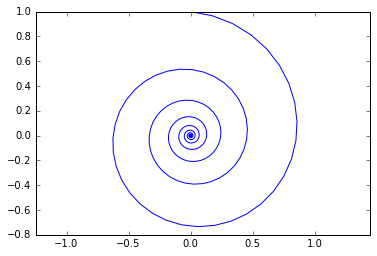

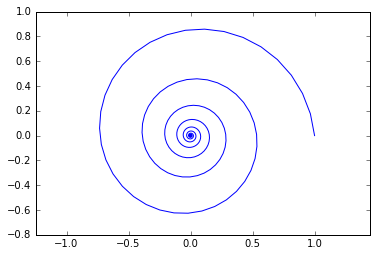

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

t = np.linspace(0, 20 * np.pi, 350)
x = np.exp(-0.1 * t) * np.sin(t)
y = np.exp(-0.1 * t) * np.cos(t)

plt.plot(x, y)
plt.axis('equal')

plt.figure()
plt.plot(y, x)
plt.axis('equal')

print('Length of t = {}'.format(len(t)))
print('x .dot. y = {}'.format(x @ y))

Nice, success! Now my code blocks [export more cleanly to jupyter notebooks](http://kitchingroup.cheme.cmu.edu/blog/2017/01/21/Exporting-org-mode-to-Jupyter-notebooks/). Speaking of which, if you liked the post on that, there is a new library for it in scimax: [https://github.com/jkitchin/scimax/blob/master/ox-ipynb.el](https://github.com/jkitchin/scimax/blob/master/ox-ipynb.el). Yes, one day I will put it in its own repo, and probably put it up on MELPA. If it turns out to be useful over the next semester. 


# code for getting output and inline figures

I wrote one new function that writes the base64 data out to a temporary file and returns a link to it. Then, I modified the org-babel-execute:ipython function to append these links onto the output. It seems like you need to use a header like this in your ob-ipython block, notably the results need to be in a drawer like this.

    #+BEGIN_SRC ipython :session :results output drawer

Here is the code.

    (defun ob-ipython-inline-image (b64-string)
      "Write the b64-string to a temporary file.
    Returns an org-link to the file."
      (let* ((tfile (make-temp-file "ob-ipython-" nil ".png"))
    	 (link (format "[[file:%s]]" tfile)))
        (ob-ipython--write-base64-string tfile b64-string)
        link))
    
    
    (defun org-babel-execute:ipython (body params)
      "Execute a block of IPython code with Babel.
    This function is called by `org-babel-execute-src-block'."
      (let* ((file (cdr (assoc :file params)))
             (session (cdr (assoc :session params)))
             (result-type (cdr (assoc :result-type params))))
        (org-babel-ipython-initiate-session session params)
        (-when-let (ret (ob-ipython--eval
                         (ob-ipython--execute-request
                          (org-babel-expand-body:generic (encode-coding-string body 'utf-8)
                                                         params (org-babel-variable-assignments:python params))
                          (ob-ipython--normalize-session session))))
          (let ((result (cdr (assoc :result ret)))
                (output (cdr (assoc :output ret))))
            (if (eq result-type 'output)
    	    (concat
    	     output 
    	     (format "%s"
    		     (mapconcat 'identity
    				(loop for res in result
    				      if (eq 'image/png (car res))
    				      collect (ob-ipython-inline-image (cdr res)))
    				"\n")))
              (ob-ipython--create-stdout-buffer output)
              (cond ((and file (string= (f-ext file) "png"))
                     (->> result (assoc 'image/png) cdr (ob-ipython--write-base64-string file)))
                    ((and file (string= (f-ext file) "svg"))
                     (->> result (assoc 'image/svg+xml) cdr (ob-ipython--write-string-to-file file)))
                    (file (error "%s is currently an unsupported file extension." (f-ext file)))
                    (t (->> result (assoc 'text/plain) cdr))))))))

    org-babel-execute:ipython

